In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.evaluation import run_noise_experiment, calc_av_p_scores, construct_single_box_df, _compute_prec_rec_f1, _select_significant_entries, get_tp_fn_fn, adjust_box_widths, get_auc
from pals.feature_extraction import DataSource

from pals.PALS import PALS
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *

2020-01-27 14:53:49.689 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-01-27 14:53:49.690 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-01-27 14:53:50.756 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
sample_fnames = control_fnames + case_fnames
true_answers = set(pathway_names.keys())

num_iterations = 500
bg_pw = 100
gsea_resamples = 1000
min_replace = 5000
plage_weight = 5
hg_weight = 1
prob_missing_peaks = 0.2

# pbar = True
# parallel = False

pbar = False
parallel = True

base_dir = os.path.join('test_data', 'synthetic')
create_if_not_exist(base_dir)

Try generating some synthetic data without noise

In [ ]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=bg_pw)
print(int_df.shape)
print(updated_pathway_names)

out_file = os.path.join(base_dir, 'simulated_intensity.eps')
plot_intensity_matrix(int_df, out_file=out_file)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [ ]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

In [ ]:
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

In [ ]:
ora = ORA(ds)
ora_df = ora.get_pathway_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

In [ ]:
gsea = GSEA(ds, random_sets=gsea_resamples, pbar=pbar)
gsea_df = gsea.get_pathway_df()
gsea_df.sort_values('pw_name')

Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

In [ ]:
percent = 250
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [ ]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

In [ ]:
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

In [ ]:
ora = ORA(ds)
ora_df = ora.get_pathway_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

In [ ]:
gsea = GSEA(ds, random_sets=gsea_resamples, pbar=True)
gsea_df = gsea.get_pathway_df()
gsea_df.sort_values('pw_name')

### Experiments

### Experiment 1: adding noise

In [7]:
prob_missing_peaks = 0.20
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 25, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks, },        
    { 'noise_std': noise_std, 'percent': 250, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks, },
]

#### Run experiment

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [ ]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, reqd_scenarios, pbar=pbar, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [8]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [9]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [10]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [11]:
filtered_pals_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3477.0  0.2  2.775957e-17  0.2  0.2  0.2  0.2  0.2    3477.0   
25.0          3495.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3495.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3499.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3499.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value           comb_p_value                      \
        mean  ...       75%       max        count      mean       std   
percent       ...                                                        
0.0      5.0  ...  0.018667  0.909758       3477.0  0.031962  0.072255   
25.0     5.0  ...  0.029437  1.000000       3495.0  0.064468  0.168082   
50.0     5.0  ...  0.036390  1.000000       3497.0  0.073149  0.180013   
100.0    5.0  ...  0.051171  1.000000       3499.0  0.093546  0.209142   
250.0    5.0  ...  0.118236  1.000000       3500.0  0.156459  0.279641   
500.0    5.0  ...  0.292814  1.000000       3500.0  0.235320  0.343953   
1000.0   5.0  ...  0.783814  1.000000       3500.0  0.350524  0.401666   

                                                               
                  min       25%       50%       75%       max  
percent                                                        
0.0      5.445046e-07  0.001334  0.006817  0.027464  0.951223  
25.0     3.691932e-06  0.001691  0.009480  0.042981  1.000000  
50.0     1.329711e-06  0.002083  0.010954  0.050660  1.000000  
100.0    1.903878e-06  0.002512  0.014022  0.066424  1.000000  
250.0    1.347975e-06  0.004120  0.025842  0.141943  1.000000  
500.0    1.504560e-05  0.007073  0.046313  0.314752  1.000000  
1000.0   3.396620e-06  0.013628  0.116526  0.789354  1.000000  

[7 rows x 32 columns]

In [12]:
filtered_ora_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3477.0  0.2  2.775957e-17  0.2  0.2  0.2  0.2  0.2    3477.0   
25.0          3495.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3495.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3499.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3499.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value      comb_p_value                      \
        mean  ...       75%  max        count      mean       std   
percent       ...                                                   
0.0      5.0  ...  0.000684  1.0       3477.0  0.078661  0.231693   
25.0     5.0  ...  0.002429  1.0       3495.0  0.109292  0.257939   
50.0     5.0  ...  0.003645  1.0       3497.0  0.120541  0.271902   
100.0    5.0  ...  0.009436  1.0       3499.0  0.160640  0.297977   
250.0    5.0  ...  0.025629  1.0       3500.0  0.292876  0.412238   
500.0    5.0  ...  0.085191  1.0       3500.0  0.413682  0.442803   
1000.0   5.0  ...  0.197929  1.0       3500.0  0.602017  0.446463   

                                                              
                  min           25%       50%       75%  max  
percent                                                       
0.0      7.446346e-76  4.700501e-24  0.000002  0.013651  1.0  
25.0     8.981223e-62  1.983679e-20  0.000030  0.049339  1.0  
50.0     2.236147e-56  2.135044e-17  0.000102  0.072032  1.0  
100.0    4.731611e-45  6.159780e-14  0.000845  0.178619  1.0  
250.0    4.238736e-30  1.968551e-08  0.015519  0.483500  1.0  
500.0    2.536690e-21  9.306543e-05  0.169762  1.000000  1.0  
1000.0   6.854192e-13  3.532895e-02  1.000000  1.000000  1.0  

[7 rows x 32 columns]

In [13]:
filtered_gsea_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3477.0  0.2  2.775957e-17  0.2  0.2  0.2  0.2  0.2    3477.0   
25.0          3495.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3495.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3499.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3499.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value           comb_p_value                           \
        mean  ...       75%       max        count      mean       std  min   
percent       ...                                                             
0.0      5.0  ...  0.003810  0.143141       3477.0  0.005387  0.014219  0.0   
25.0     5.0  ...  0.015764  0.985915       3495.0  0.023676  0.072557  0.0   
50.0     5.0  ...  0.019724  0.964657       3497.0  0.027466  0.077858  0.0   
100.0    5.0  ...  0.030075  0.991853       3499.0  0.038765  0.098171  0.0   
250.0    5.0  ...  0.051716  0.981520       3500.0  0.058597  0.120874  0.0   
500.0    5.0  ...  0.101735  0.935167       3500.0  0.089814  0.154656  0.0   
1000.0   5.0  ...  0.260341  0.983573       3500.0  0.169024  0.210821  0.0   

                                                
             25%       50%       75%       max  
percent                                         
0.0      0.00000  0.000000  0.003810  0.143141  
25.0     0.00000  0.000000  0.015764  0.985915  
50.0     0.00000  0.000000  0.019724  0.964657  
100.0    0.00000  0.000000  0.030075  0.991853  
250.0    0.00000  0.010000  0.051716  0.981520  
500.0    0.00000  0.020305  0.101735  0.935167  
1000.0   0.01537  0.071285  0.260341  0.983573  

[7 rows x 32 columns]

Define seaborn styles. This will affect all plots from hereon.

In [14]:
sns.set(style="ticks")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


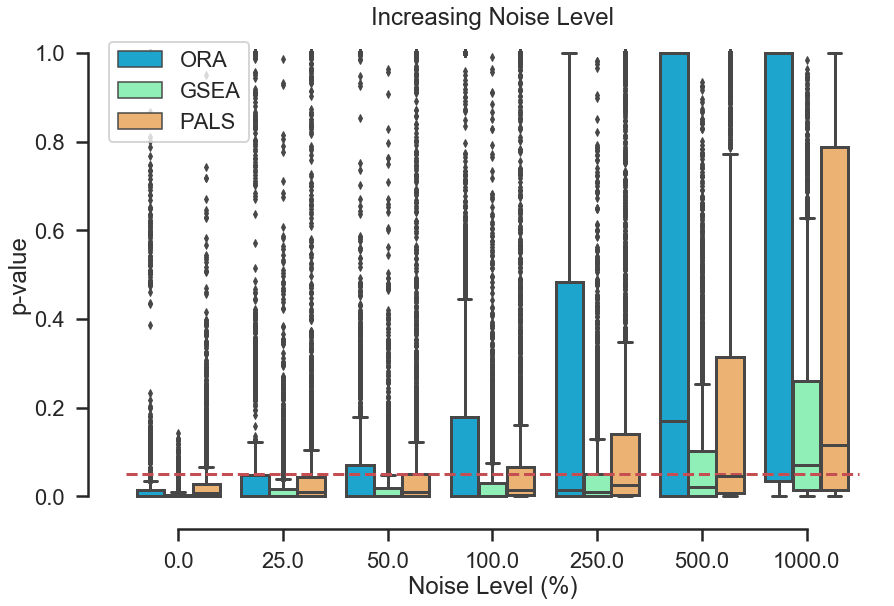

In [15]:
ax = sns.boxplot(x="percent", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Increasing Noise Level')
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'adding_noise.eps')
plt.savefig(out_file, dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


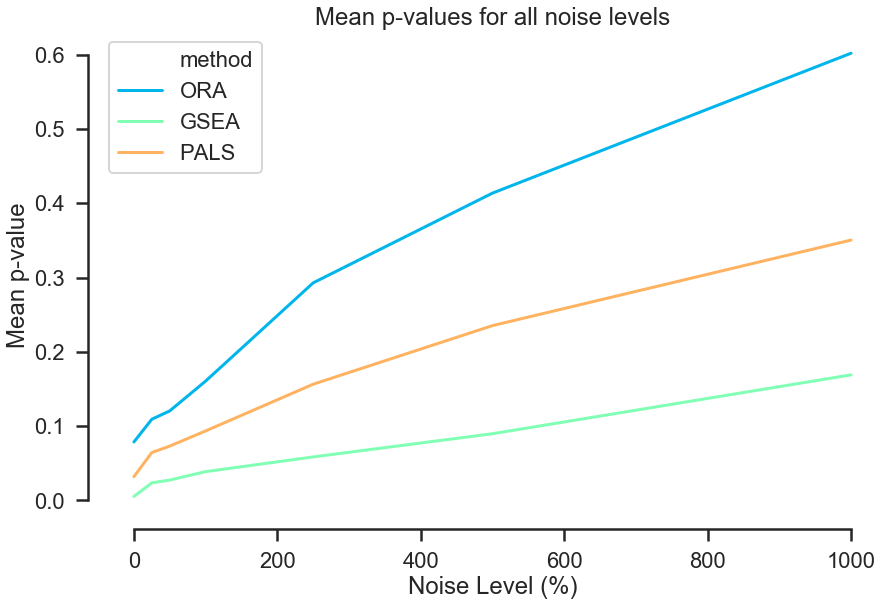

In [16]:
pals_pvalue_mean = pd.DataFrame(filtered_pals_df.groupby('percent').describe()['comb_p_value']['mean'])
ora_pvalue_mean = pd.DataFrame(filtered_ora_df.groupby('percent').describe()['comb_p_value']['mean'])
gsea_pvalue_mean = pd.DataFrame(filtered_gsea_df.groupby('percent').describe()['comb_p_value']['mean'])

pals_pvalue_mean['method'] = 'PALS'
ora_pvalue_mean['method'] = 'ORA'
gsea_pvalue_mean['method'] = 'GSEA'
combined_df = pd.concat([pals_pvalue_mean, ora_pvalue_mean, gsea_pvalue_mean])

ax = sns.lineplot(data=combined_df.reset_index(), x='percent', y='mean', hue='method', hue_order=['ORA', 'GSEA', 'PALS'], palette='rainbow')
ax.set(xlabel='Noise Level (%)', ylabel='Mean p-value')
plt.title('Mean p-values for all noise levels')

plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

#### Plot for individual pathways

Make lineplot

In [17]:
sns.set(style="whitegrid")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


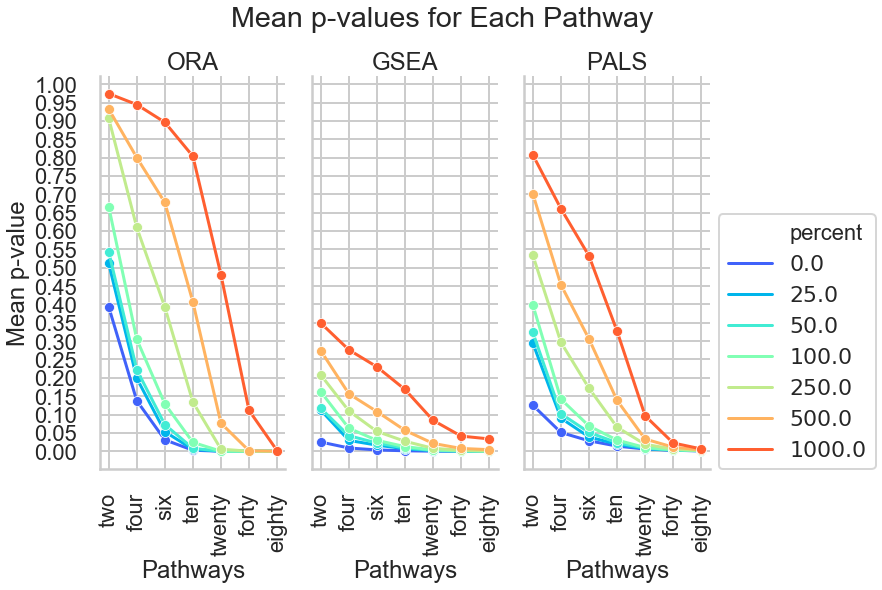

In [18]:
fig, axes = plt.subplots(1, 3, sharey=True)

df = filtered_ora_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[0], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('ORA')

df = filtered_gsea_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[1], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('GSEA')

df = filtered_pals_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[2], legend='brief')
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('PALS')

ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
         # it will place the legend on the outer right-hand side of the last axes
    
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    
plt.suptitle('Mean p-values for Each Pathway')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

Make barplots

In [19]:
filtered_pals_df['pathway'] = pd.Categorical(filtered_pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_ora_df['pathway'] = pd.Categorical(filtered_ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_gsea_df['pathway'] = pd.Categorical(filtered_gsea_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

filtered_pals_df = filtered_pals_df.sort_values('pathway')
filtered_ora_df = filtered_ora_df.sort_values('pathway')
filtered_gsea_df = filtered_gsea_df.sort_values('pathway')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


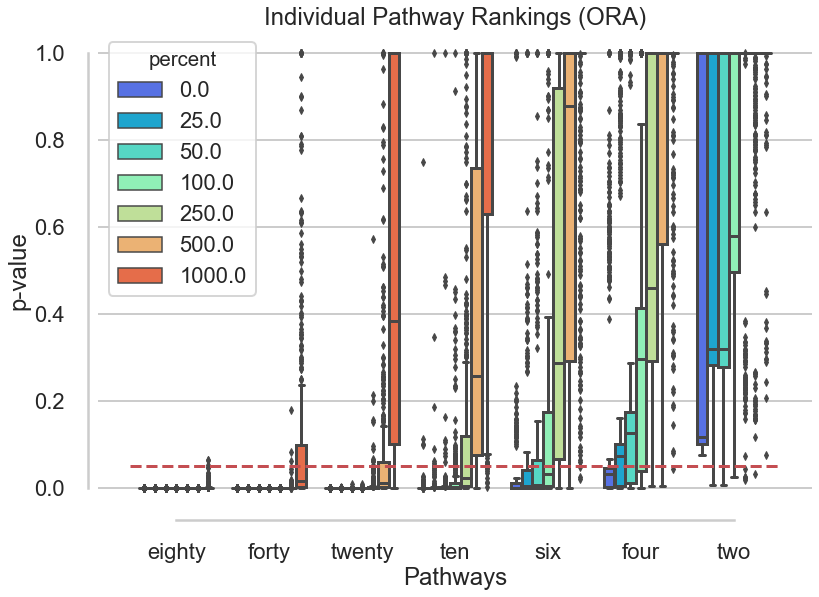

In [20]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_ora_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (ORA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_ora.eps')
plt.savefig(out_file, dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


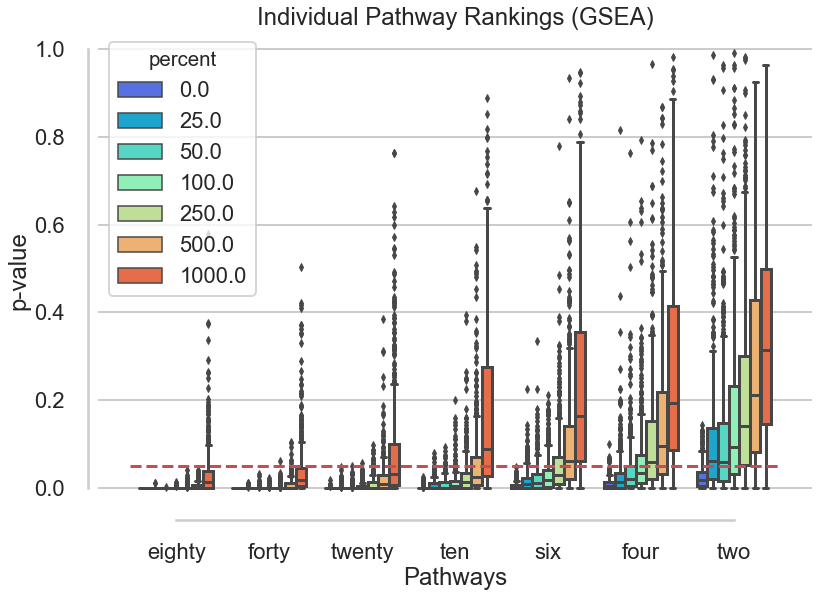

In [21]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_gsea_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (GSEA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_gsea.eps')
plt.savefig(out_file, dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


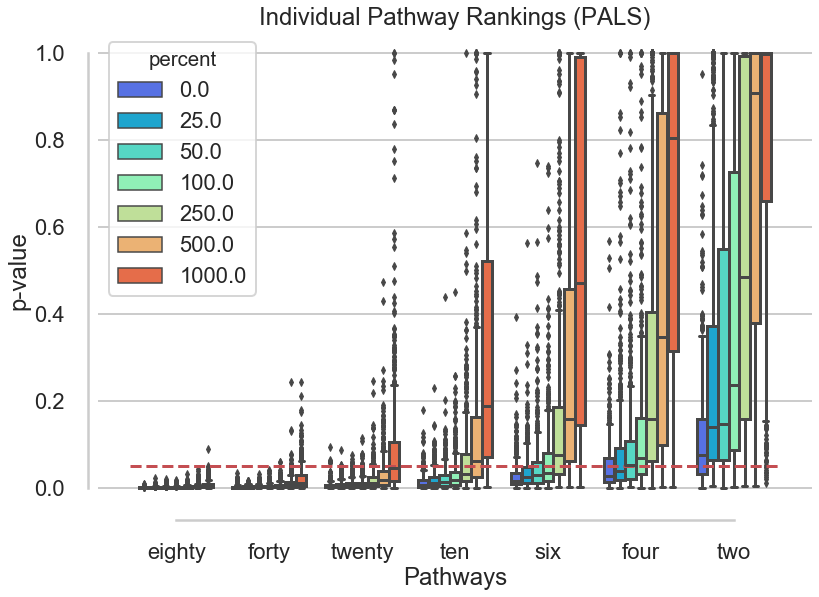

In [22]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_pals_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (PALS)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_pals.eps')
plt.savefig(out_file, dpi=300)

#### Better analysis where we consider TP, FP, FN

In [23]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
df

,method,noise_std,percent,prob_missing_peaks,TP,FP,FN,prec,rec,f1
0,PALS,5,0,0.2,5,0,2,1.000000,0.714286,0.833333
1,PALS,5,0,0.2,6,0,1,1.000000,0.857143,0.923077
2,PALS,5,0,0.2,5,0,2,1.000000,0.714286,0.833333
3,PALS,5,0,0.2,5,0,2,1.000000,0.714286,0.833333
4,PALS,5,0,0.2,7,0,0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
10495,GSEA,5,1000,0.2,4,10,3,0.285714,0.571429,0.380952
10496,GSEA,5,1000,0.2,1,4,6,0.200000,0.142857,0.166667
10497,GSEA,5,1000,0.2,4,4,3,0.500000,0.571429,0.533333
10498,GSEA,5,1000,0.2,2,2,5,0.500000,0.285714,0.363636


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


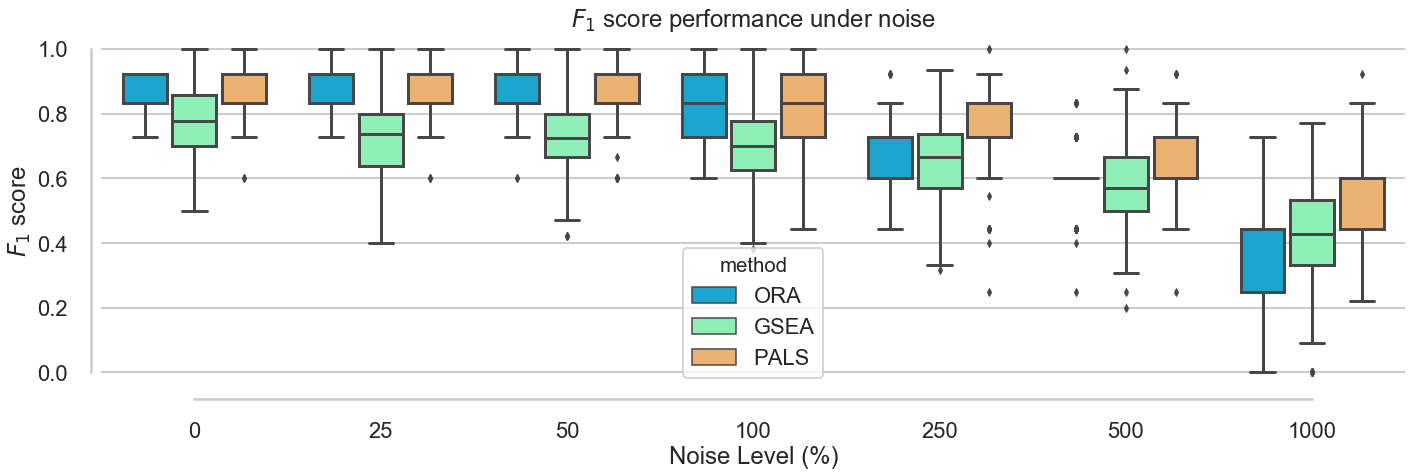

In [24]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='$F_{1}$ score')
plt.title('$F_{1}$ score performance under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_noise.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [25]:
auc_df = get_auc(reqd_scenarios, exp_results, true_answers)

{'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2} PALS 0.923
{'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2} ORA 0.601
{'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2} GSEA 0.828

{'noise_std': 5, 'percent': 25, 'prob_missing_peaks': 0.2} PALS 0.911
{'noise_std': 5, 'percent': 25, 'prob_missing_peaks': 0.2} ORA 0.611
{'noise_std': 5, 'percent': 25, 'prob_missing_peaks': 0.2} GSEA 0.760

{'noise_std': 5, 'percent': 50, 'prob_missing_peaks': 0.2} PALS 0.908
{'noise_std': 5, 'percent': 50, 'prob_missing_peaks': 0.2} ORA 0.601
{'noise_std': 5, 'percent': 50, 'prob_missing_peaks': 0.2} GSEA 0.745

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} PALS 0.898
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} ORA 0.605
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} GSEA 0.711

{'noise_std': 5, 'percent': 250, 'prob_missing_peaks': 0.2} PALS 0.861
{'noise_std': 5, 'percent': 250, 'prob_missing_peaks': 0.2} ORA 0.588
{'noise_std': 5, 'p

In [26]:
auc_df

,method,noise_std,percent,prob_missing_peaks,iter,auc
0,PALS,5,0,0.2,0,0.934579
1,PALS,5,0,0.2,1,0.918706
2,PALS,5,0,0.2,2,0.934579
3,PALS,5,0,0.2,3,0.925651
4,PALS,5,0,0.2,4,0.934579
...,...,...,...,...,...,...
10495,GSEA,5,1000,0.2,495,0.369257
10496,GSEA,5,1000,0.2,496,0.239728
10497,GSEA,5,1000,0.2,497,0.625506
10498,GSEA,5,1000,0.2,498,0.360486


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


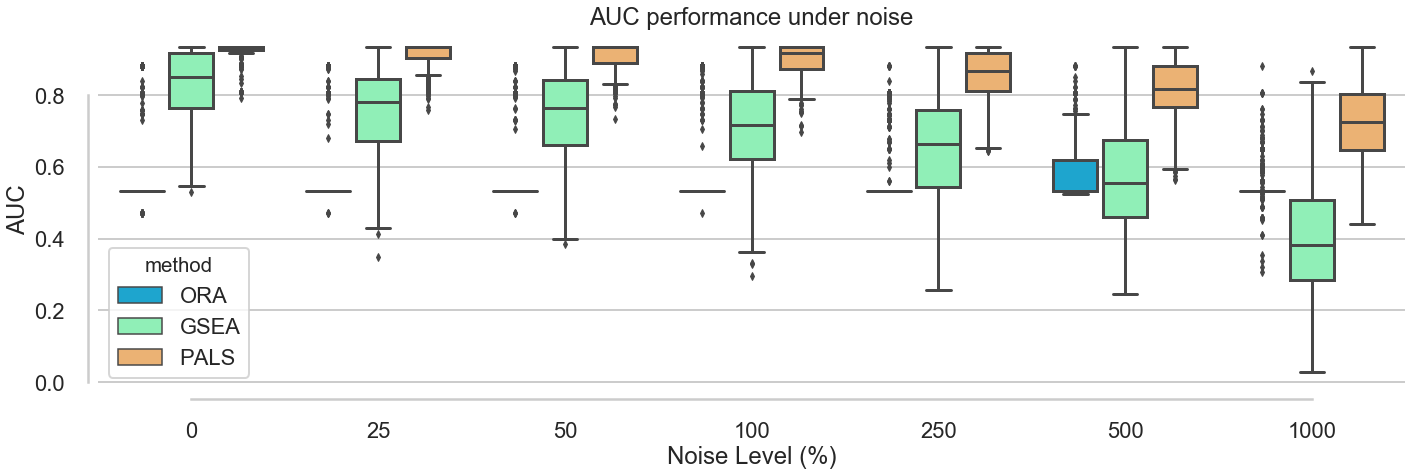

In [27]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='AUC')
plt.title('AUC performance under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_noise.eps')
plt.savefig(out_file, dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [28]:
percent = 100
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.1, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.2, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.3, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.4, },        
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.5, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.6, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.7, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.8, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.9, },
]

#### Run experiment

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, reqd_scenarios, pbar=pbar, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [29]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [30]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [31]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [32]:
filtered_pals_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.1           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.2           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.3           3494.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3494.0   
0.4           3489.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3489.0   
0.5           3468.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3468.0   
0.6           3431.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3431.0   
0.7           3335.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3335.0   
0.8           3215.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3215.0   
0.9           2737.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    2737.0   

                   ...   p_value      comb_p_value                      \
             mean  ...       75%  max        count      mean       std   
prob_missing       ...                                                   
0.1           5.0  ...  0.043096  1.0       3500.0  0.077032  0.175197   
0.2           5.0  ...  0.048716  1.0       3500.0  0.092469  0.208440   
0.3           5.0  ...  0.064535  1.0       3494.0  0.117279  0.245467   
0.4           5.0  ...  0.080220  1.0       3489.0  0.139621  0.274898   
0.5           5.0  ...  0.125680  1.0       3468.0  0.174747  0.309438   
0.6           5.0  ...  0.170008  1.0       3431.0  0.207930  0.341419   
0.7           5.0  ...  0.296704  1.0       3335.0  0.244443  0.367134   
0.8           5.0  ...  0.593632  1.0       3215.0  0.298618  0.397939   
0.9           5.0  ...  0.819177  1.0       2737.0  0.337583  0.409397   

                                                               
                       min       25%       50%       75%  max  
prob_missing                                                   
0.1           4.006539e-06  0.002449  0.013508  0.060446  1.0  
0.2           5.216591e-07  0.002546  0.014006  0.064085  1.0  
0.3           5.338564e-07  0.002982  0.016013  0.078479  1.0  
0.4           3.418205e-06  0.003225  0.017484  0.102047  1.0  
0.5           2.083214e-06  0.003967  0.023185  0.146188  1.0  
0.6           2.413260e-06  0.004721  0.027687  0.201817  1.0  
0.7           4.839555e-06  0.005241  0.035361  0.324204  1.0  
0.8           1.056962e-05  0.007409  0.052695  0.623318  1.0  
0.9           2.534556e-05  0.012101  0.086544  0.817276  1.0  

[9 rows x 32 columns]

In [33]:
filtered_ora_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.1           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.2           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.3           3494.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3494.0   
0.4           3489.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3489.0   
0.5           3468.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3468.0   
0.6           3431.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3431.0   
0.7           3335.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3335.0   
0.8           3215.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3215.0   
0.9           2737.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    2737.0   

                   ...   p_value      comb_p_value                      \
             mean  ...       75%  max        count      mean       std   
prob_missing       ...                                                   
0.1           5.0  ...  0.003225  1.0       3500.0  0.138529  0.274374   
0.2           5.0  ...  0.008580  1.0       3500.0  0.161820  0.299746   
0.3           5.0  ...  0.014628  1.0       3494.0  0.203020  0.343998   
0.4           5.0  ...  0.021104  1.0       3489.0  0.249962  0.384453   
0.5           5.0  ...  0.046238  1.0       3468.0  0.299145  0.415024   
0.6           5.0  ...  0.074446  1.0       3431.0  0.360850  0.440841   
0.7           5.0  ...  0.115796  1.0       3335.0  0.420644  0.451981   
0.8           5.0  ...  0.170354  1.0       3215.0  0.509003  0.461392   
0.9           5.0  ...  0.196183  1.0       2737.0  0.630551  0.438397   

                                                                   
                       min           25%       50%       75%  max  
prob_missing                                                       
0.1           2.584074e-48  2.590801e-16  0.000256  0.060101  1.0  
0.2           1.417430e-45  1.127216e-13  0.000624  0.170411  1.0  
0.3           1.071206e-44  1.574356e-11  0.001498  0.268143  1.0  
0.4           6.065166e-36  1.213205e-09  0.005255  0.385792  1.0  
0.5           4.365994e-32  1.054023e-07  0.014530  0.744490  1.0  
0.6           2.702600e-28  3.639181e-06  0.047739  1.000000  1.0  
0.7           2.591915e-23  7.783061e-05  0.127989  1.000000  1.0  
0.8           8.901798e-18  3.930086e-03  0.432168  1.000000  1.0  
0.9           9.735413e-13  8.211728e-02  1.000000  1.000000  1.0  

[9 rows x 32 columns]

In [34]:
filtered_gsea_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.1           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.2           3500.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3500.0   
0.3           3494.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3494.0   
0.4           3489.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3489.0   
0.5           3468.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3468.0   
0.6           3431.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3431.0   
0.7           3335.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3335.0   
0.8           3215.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3215.0   
0.9           2737.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    2737.0   

                   ...   p_value           comb_p_value                      \
             mean  ...       75%       max        count      mean       std   
prob_missing       ...                                                        
0.1           5.0  ...  0.022941  0.753398       3500.0  0.027757  0.067054   
0.2           5.0  ...  0.028630  0.987854       3500.0  0.036122  0.088927   
0.3           5.0  ...  0.034483  0.983968       3494.0  0.047036  0.115106   
0.4           5.0  ...  0.046185  0.985656       3489.0  0.059562  0.135275   
0.5           5.0  ...  0.058852  0.995910       3468.0  0.071918  0.156403   
0.6           5.0  ...  0.074074  0.995918       3431.0  0.089400  0.176965   
0.7           5.0  ...  0.097689  0.992157       3335.0  0.104813  0.195432   
0.8           5.0  ...  0.151481  0.988484       3215.0  0.134085  0.223313   
0.9           5.0  ...  0.181996  0.992048       2737.0  0.155588  0.234486   

                                                          
              min      25%       50%       75%       max  
prob_missing                                              
0.1           0.0  0.00000  0.000000  0.022941  0.753398  
0.2           0.0  0.00000  0.000000  0.028630  0.987854  
0.3           0.0  0.00000  0.003956  0.034483  0.983968  
0.4           0.0  0.00000  0.006173  0.046185  0.985656  
0.5           0.0  0.00000  0.008290  0.058852  0.995910  
0.6           0.0  0.00000  0.012245  0.074074  0.995918  
0.7           0.0  0.00000  0.017613  0.097689  0.992157  
0.8           0.0  0.00000  0.026749  0.151481  0.988484  
0.9           0.0  0.00823  0.042802  0.181996  0.992048  

[9 rows x 32 columns]

In [35]:
# style.use('seaborn-poster') #sets the size of the charts
# sns.set(style="whitegrid")
# style.use('ggplot')
# sns.set_context('poster')  #Everything is larger

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


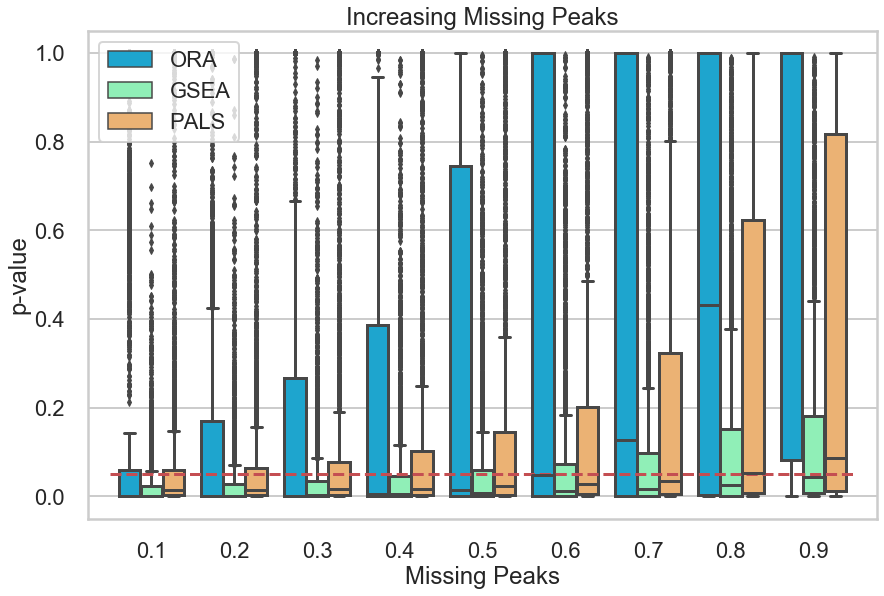

In [36]:
ax = sns.boxplot(x="prob_missing", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='p-value')
plt.plot([-0.5, 8.5], [0.05, 0.05], 'r--')
plt.title('Increasing Missing Peaks')
plt.legend(loc='upper left')
plt.tight_layout()

out_file = os.path.join(base_dir, 'missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Better analysis where we consider TP, FP, FN

In [37]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
df

,method,noise_std,percent,prob_missing_peaks,TP,FP,FN,prec,rec,f1
0,PALS,5,100,0.1,6,0,1,1.000000,0.857143,0.923077
1,PALS,5,100,0.1,4,0,3,1.000000,0.571429,0.727273
2,PALS,5,100,0.1,6,0,1,1.000000,0.857143,0.923077
3,PALS,5,100,0.1,4,0,3,1.000000,0.571429,0.727273
4,PALS,5,100,0.1,6,0,1,1.000000,0.857143,0.923077
...,...,...,...,...,...,...,...,...,...,...
13495,GSEA,5,100,0.9,3,6,4,0.333333,0.428571,0.375000
13496,GSEA,5,100,0.9,2,2,5,0.500000,0.285714,0.363636
13497,GSEA,5,100,0.9,4,6,3,0.400000,0.571429,0.470588
13498,GSEA,5,100,0.9,4,4,3,0.500000,0.571429,0.533333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


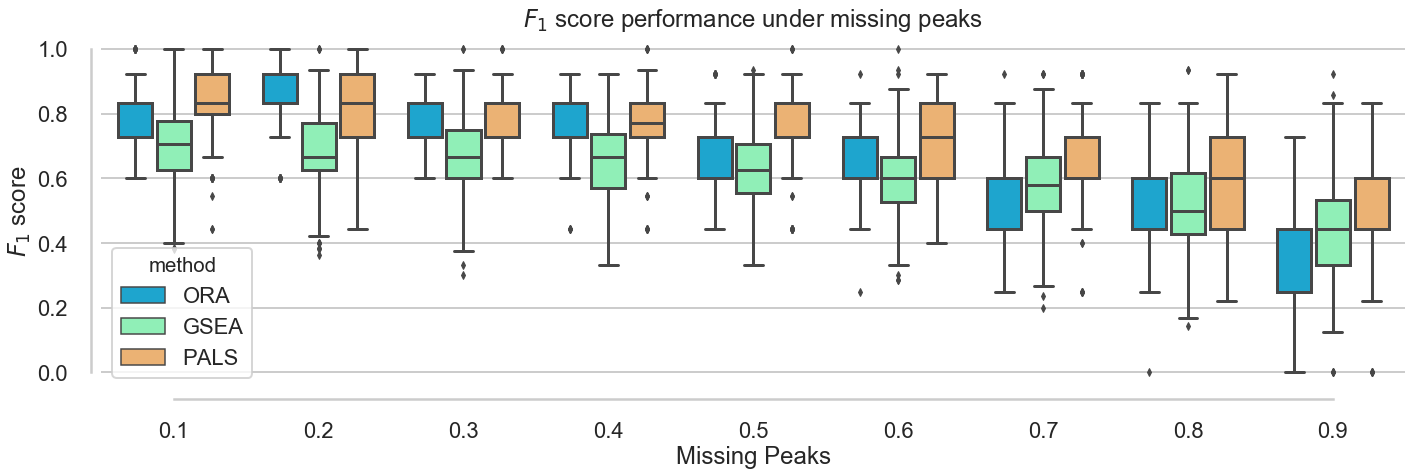

In [48]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='$F_{1}$ score')
plt.title('$F_{1}$ score performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [42]:
auc_df = get_auc(reqd_scenarios, exp_results, true_answers)

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.1} PALS 0.909
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.1} ORA 0.603
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.1} GSEA 0.727

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} PALS 0.897
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} ORA 0.598
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2} GSEA 0.706

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.3} PALS 0.881
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.3} ORA 0.612
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.3} GSEA 0.692

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.4} PALS 0.862
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.4} ORA 0.608
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.4} GSEA 0.669

{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.5} PALS 0.838
{'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.5} ORA 0.603
{'noise

In [43]:
auc_df

,method,noise_std,percent,prob_missing_peaks,iter,auc
0,PALS,5,100,0.1,0,0.848650
1,PALS,5,100,0.1,1,0.934579
2,PALS,5,100,0.1,2,0.902947
3,PALS,5,100,0.1,3,0.918706
4,PALS,5,100,0.1,4,0.934579
...,...,...,...,...,...,...
13495,GSEA,5,100,0.9,495,0.194673
13496,GSEA,5,100,0.9,496,0.308229
13497,GSEA,5,100,0.9,497,0.425413
13498,GSEA,5,100,0.9,498,0.404276


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


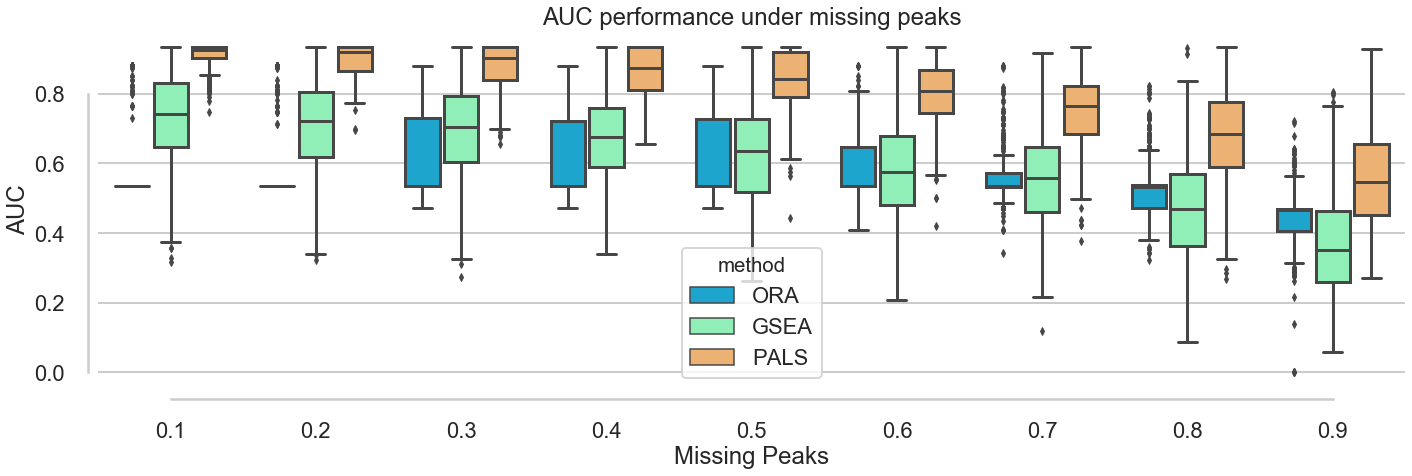

In [47]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='AUC')
plt.title('AUC performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

### Experiment 3: Nothing is changing, it's all random

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    warnings.filterwarnings('ignore', r'invalid value encountered')
    results = calc_av_p_scores(case_fnames, control_fnames, pathway_names, 1, random=True, plage_weight=plage_weight, hg_weight=hg_weight, gsea_resamples=gsea_resamples, background_pathways=bg_pw, pbar=pbar)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'PALS')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ORA')   
    gsea_df = construct_single_box_df(results, 100, 0.2, 1, 'GSEA')   

In [ ]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()

In [ ]:
filtered_ora_df

In [ ]:
filtered_pals_df

In [ ]:
filtered_gsea_df